# Notebook to predict the length of Stay using Multilayer perception and BI-Directional LSTM


Import Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


copy datset to disk and unzip

In [2]:
!cp "/content/drive/MyDrive/dataset.zip" -r "/content"

In [3]:
!unzip "/content/drive/MyDrive/dataset.zip"

Archive:  /content/drive/MyDrive/dataset.zip
   creating: new/
  inflating: __MACOSX/._new          
  inflating: new/pyxis.csv           
  inflating: __MACOSX/new/._pyxis.csv  
  inflating: new/top198historical_icd.csv  
  inflating: __MACOSX/new/._top198historical_icd.csv  
  inflating: new/vitalsign.csv       
  inflating: __MACOSX/new/._vitalsign.csv  
  inflating: new/medrecon.csv        
  inflating: __MACOSX/new/._medrecon.csv  
  inflating: new/previous_icd_code.csv  
  inflating: __MACOSX/new/._previous_icd_code.csv  
  inflating: new/triage.csv          
  inflating: __MACOSX/new/._triage.csv  
  inflating: new/edstays.csv         
  inflating: __MACOSX/new/._edstays.csv  
  inflating: new/diagnosis.csv       
  inflating: __MACOSX/new/._diagnosis.csv  


###### Import required libraries

In [4]:
import numpy as np
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score
from keras.utils import to_categorical
#tf.compat.v1.disable_v2_behavior()

Confirm keras version

In [5]:
keras.__version__

'2.9.0'

In [6]:
!ls "/content/new"

diagnosis.csv  medrecon.csv	      pyxis.csv			triage.csv
edstays.csv    previous_icd_code.csv  top198historical_icd.csv	vitalsign.csv


Read in CSV files for data modelling: Files used

1.   Edstays
2.   Triage
3.   Top 198 Historical ICD
4.   Previous ICD Codes



In [7]:
edstays = pd.read_csv("/content/new/edstays.csv")
triage = pd.read_csv('/content/new/triage.csv')
his_icd_top198 = pd.read_csv('/content/new/top198historical_icd.csv')
df_pre_icd_full = pd.read_csv('/content/new/previous_icd_code.csv')

edstays.tail()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
447707,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED
447708,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED
447709,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED
447710,19999914,NaN,32002659,24/12/2158 11:41,24/12/2158 11:56,F,UNKNOWN,UNKNOWN,ELOPED
447711,19999987,23865745.0,34731548,2/11/2145 19:28,2/11/2145 22:59,F,UNKNOWN,AMBULANCE,ADMITTED


## Data Cleaning

Create a function to either make pandas dummy variables and to categorize columns

In [8]:

def dummyfy(data,me):
  dummies = pd.get_dummies (data[me]) #get the dummies
  data = pd.concat([dummies,data], axis=1) # join it to the dataset
  data = data.drop(me, axis=1) #drop it, you don't need it again
  return data

def categorify(data,me):
  data[me] = data[me].astype("category") # convert to category type
  data[me] = data[me].cat.codes
  data = data.drop(me, axis=1)
  return data

In [9]:
edstays.tail()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
447707,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED
447708,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED
447709,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED
447710,19999914,NaN,32002659,24/12/2158 11:41,24/12/2158 11:56,F,UNKNOWN,UNKNOWN,ELOPED
447711,19999987,23865745.0,34731548,2/11/2145 19:28,2/11/2145 22:59,F,UNKNOWN,AMBULANCE,ADMITTED


In [10]:
data = pd.merge(edstays,triage,how = 'left',on=['subject_id', 'stay_id'])
data.tail()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
447707,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,98.6,80.0,18.0,100.0,161.0,100.0,0,3.0,L Leg weakness
447708,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,96.6,112.0,18.0,100.0,110.0,82.0,4,2.0,"Abd pain, Wound eval"
447709,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,98.1,83.0,18.0,100.0,107.0,75.0,8,2.0,"Abd pain, Wound eval"
447710,19999914,NaN,32002659,24/12/2158 11:41,24/12/2158 11:56,F,UNKNOWN,UNKNOWN,ELOPED,99.5,81.0,10.0,100.0,93.0,55.0,0,2.0,"Altered mental status, Substance use"
447711,19999987,23865745.0,34731548,2/11/2145 19:28,2/11/2145 22:59,F,UNKNOWN,AMBULANCE,ADMITTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEAD BLEED


In [11]:
data.pain = pd.to_numeric(data.pain, errors = "coerce")
data.pain

0          0.0
1         10.0
2         10.0
3          7.0
4         13.0
          ... 
447707     0.0
447708     4.0
447709     8.0
447710     0.0
447711     NaN
Name: pain, Length: 447712, dtype: float64

In [12]:
data.fillna(method = "ffill", inplace=True)

Store target as variable Y_var

In [13]:
def categorize_hours(x):
  if x<=6:
    return(0)# for Class ("0 - 6")
  elif x<=12:
    return(1)# for Class ("6 - 12")
  elif x<=24:
    return(2)# for Class ("12 - 24")
  else:
    return(3)# for Class ("24+")

In [14]:
Y = (pd.to_datetime(data['outtime'], format='%d/%m/%Y %H:%M') - pd.to_datetime(data['intime'], format='%d/%m/%Y %H:%M')).astype('timedelta64[h]')
data["y_var"] = [categorize_hours(x) for x in Y]

In [15]:
pd.DataFrame([categorize_hours(x) for x in Y]).value_counts()

0    293376
1    106305
2     37314
3     10717
dtype: int64

In [16]:
data

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,y_var
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention",0
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,Abdominal distention,0
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,"n/v/d, Abd pain",0
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension,2
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0,"Abdominal distention, Abd pain, LETHAGIC",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447707,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,98.6,80.0,18.0,100.0,161.0,100.0,0.0,3.0,L Leg weakness,0
447708,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,"Abd pain, Wound eval",1
447709,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,98.1,83.0,18.0,100.0,107.0,75.0,8.0,2.0,"Abd pain, Wound eval",2
447710,19999914,29734428.0,32002659,24/12/2158 11:41,24/12/2158 11:56,F,UNKNOWN,UNKNOWN,ELOPED,99.5,81.0,10.0,100.0,93.0,55.0,0.0,2.0,"Altered mental status, Substance use",0


In [17]:
data = data.drop(['intime', 'outtime'], axis=1)
data.head()

,subject_id,hadm_id,stay_id,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,y_var
0,10000032,22595853.0,33258284,F,WHITE,AMBULANCE,ADMITTED,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention",0
1,10000032,22841357.0,38112554,F,WHITE,AMBULANCE,ADMITTED,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,Abdominal distention,0
2,10000032,25742920.0,35968195,F,WHITE,AMBULANCE,ADMITTED,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,"n/v/d, Abd pain",0
3,10000032,29079034.0,32952584,F,WHITE,AMBULANCE,HOME,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension,2
4,10000032,29079034.0,39399961,F,WHITE,AMBULANCE,ADMITTED,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0,"Abdominal distention, Abd pain, LETHAGIC",1


In [18]:
data.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'race',
       'arrival_transport', 'disposition', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint',
       'y_var'],
      dtype='object')

In [19]:
edstay_ad1 = data.drop(['subject_id','hadm_id','stay_id','race', 'gender','disposition','chiefcomplaint', 'pain', 'y_var'], axis = 1)

In [20]:
edstay_ad1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447712 entries, 0 to 447711
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   arrival_transport  447712 non-null  object 
 1   temperature        447712 non-null  float64
 2   heartrate          447712 non-null  float64
 3   resprate           447712 non-null  float64
 4   o2sat              447712 non-null  float64
 5   sbp                447712 non-null  float64
 6   dbp                447712 non-null  float64
 7   acuity             447712 non-null  float64
dtypes: float64(7), object(1)
memory usage: 30.7+ MB


In [21]:
updated_edstay_ad = edstay_ad1
updated_edstay_ad['temperaturemissing'] = updated_edstay_ad['temperature'].isnull().astype(int)
updated_edstay_ad['heartratemissing'] = updated_edstay_ad['heartrate'].isnull().astype(int)
updated_edstay_ad['respratemissing'] = updated_edstay_ad['resprate'].isnull().astype(int)
updated_edstay_ad['o2satmissing'] = updated_edstay_ad['o2sat'].isnull().astype(int)
updated_edstay_ad['sbpmissing'] = updated_edstay_ad['sbp'].isnull().astype(int)
updated_edstay_ad['dbpmissing'] = updated_edstay_ad['dbp'].isnull().astype(int)
updated_edstay_ad['acuitymissing'] = updated_edstay_ad['acuity'].isnull().astype(int)

In [22]:
edstay_ad1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447712 entries, 0 to 447711
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   arrival_transport   447712 non-null  object 
 1   temperature         447712 non-null  float64
 2   heartrate           447712 non-null  float64
 3   resprate            447712 non-null  float64
 4   o2sat               447712 non-null  float64
 5   sbp                 447712 non-null  float64
 6   dbp                 447712 non-null  float64
 7   acuity              447712 non-null  float64
 8   temperaturemissing  447712 non-null  int64  
 9   heartratemissing    447712 non-null  int64  
 10  respratemissing     447712 non-null  int64  
 11  o2satmissing        447712 non-null  int64  
 12  sbpmissing          447712 non-null  int64  
 13  dbpmissing          447712 non-null  int64  
 14  acuitymissing       447712 non-null  int64  
dtypes: float64(7), int64(7), object(1)

In [23]:
num_attr = edstay_ad1.select_dtypes(include=['float64']).columns
cat_attr = edstay_ad1.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns

In [24]:
my_imputer = SimpleImputer(strategy = 'median')
updated_edstay_ad[num_attr] = my_imputer.fit_transform(updated_edstay_ad[num_attr])
updated_edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447712 entries, 0 to 447711
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   arrival_transport   447712 non-null  object 
 1   temperature         447712 non-null  float64
 2   heartrate           447712 non-null  float64
 3   resprate            447712 non-null  float64
 4   o2sat               447712 non-null  float64
 5   sbp                 447712 non-null  float64
 6   dbp                 447712 non-null  float64
 7   acuity              447712 non-null  float64
 8   temperaturemissing  447712 non-null  int64  
 9   heartratemissing    447712 non-null  int64  
 10  respratemissing     447712 non-null  int64  
 11  o2satmissing        447712 non-null  int64  
 12  sbpmissing          447712 non-null  int64  
 13  dbpmissing          447712 non-null  int64  
 14  acuitymissing       447712 non-null  int64  
dtypes: float64(7), int64(7), object(1)

In [25]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [26]:
triage_2 = data[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [27]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [28]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


# Working on the Text Data

Create a function to preprocess the texts, keep only useful characters

In [29]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Merge dataframes

In [30]:
triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

Word Cloud Distribution

In [31]:
!pip install wordcloud -qq

In [32]:
def plot_word_cloud(label, title):
  df = triage_3[triage_3['y_var']==label]
  from wordcloud import WordCloud, STOPWORDS
  comment_words = ''
  stopwords = set(STOPWORDS)


  for val in df.chiefcomplaint:
      
      # typecaste each val to string
      val = str(val)
  
      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(title)
  plt.tight_layout(pad = 0)
  plt.savefig(title+'.png')
  
  plt.show()

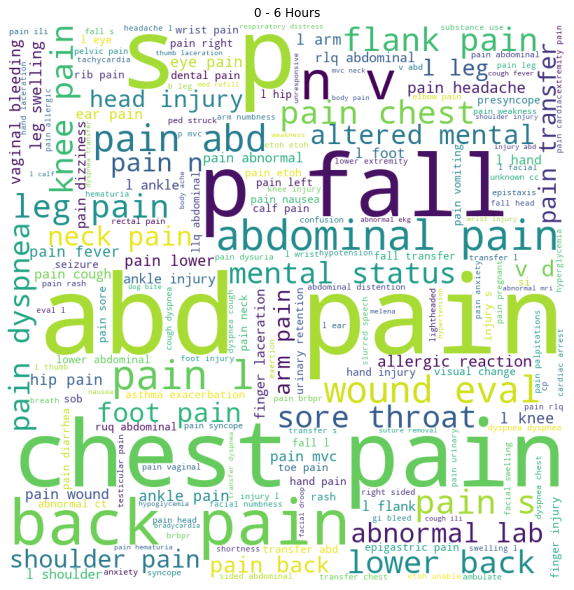

In [33]:
plot_word_cloud(0,"0 - 6 Hours")

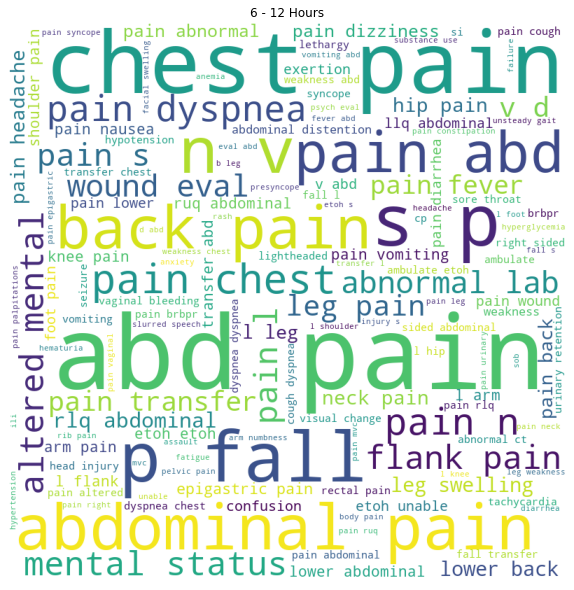

In [34]:
plot_word_cloud(1,"6 - 12 Hours")

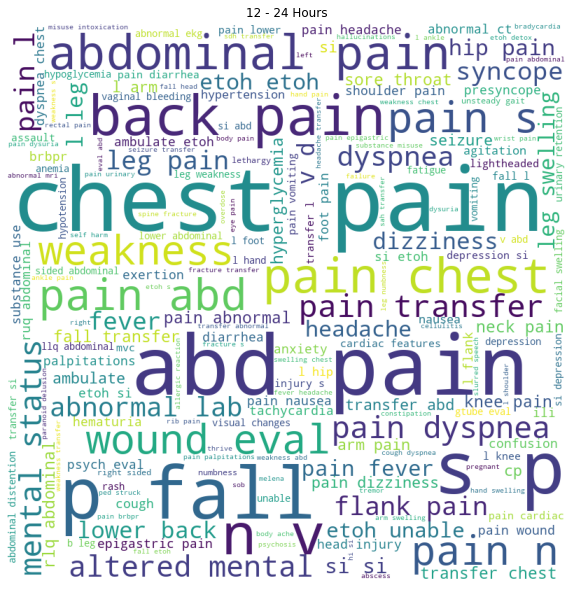

In [35]:
plot_word_cloud(2,"12 - 24 Hours")

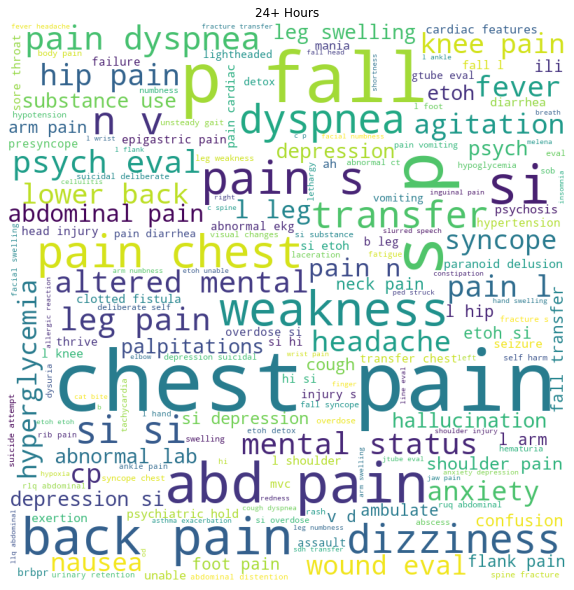

In [36]:
plot_word_cloud(3,"24+ Hours")

Create a Train Test and Validation Split

In [37]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create val index  = 0.20 to 0.30 * random index
val_index = ind[int(len(triage_3) * 0.20):int(len(triage_3) * 0.30)]
#create train index = 0.30 * random index to end
train_index = ind[int(len(triage_3) * 0.30):]

In [38]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.pre_icd_code[train_index]
val_samples_chief =  triage_3.chiefcomplaint[val_index]
val_samples_his =  triage_3.pre_icd_code[val_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.pre_icd_code[test_index]
train_samples_o =  updated_edstay_ad.iloc[train_index]
val_samples_o =  updated_edstay_ad.iloc[val_index]
test_samples_o =  updated_edstay_ad.iloc[test_index]
train_labels =  triage_3.y_var[train_index]
val_labels = triage_3.y_var[val_index]
test_labels = triage_3.y_var[test_index]

### creating Text Vectorizers

In [39]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [40]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'r']

In [41]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 20,  0])

In [42]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## Pull Pretrained Embeddings from Official Repo.
The weights are available at the repo here https://github.com/ncbi-nlp/BioSentVec#biowordvec

Using the BioWordVec vector 13GB (200dim, trained on PubMed+MIMIC-III, word2vec bin format)

In [43]:
!curl "https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin" > "BioWordVec_PubMed_MIMICIII_d200.vec.bin"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5G  100 12.5G    0     0  10.9M      0  0:19:26  0:19:26 --:--:-- 5480k


In [44]:
#load the model w2vec for chief complaint:
%%time
model_w2v = KeyedVectors.load_word2vec_format('BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

CPU times: user 2min 49s, sys: 16.5 s, total: 3min 6s
Wall time: 3min 6s


In [45]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4339 words (160 misses)


In [46]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [47]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [48]:
#check top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [49]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [50]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

## BiLSTM model.

data leveraged includes using historical and current data (historical icd code & chief complaint)

In [51]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
x_train_o = trans_pip.fit_transform(train_samples_o)
y_train = np.array(train_labels)

x_val = vectorizer(np.array([[s] for s in val_samples_chief])).numpy()
x_val_his = vectorizer_his(np.array([[s] for s in val_samples_his])).numpy()
x_val_o = trans_pip.transform(val_samples_o)
y_val = np.array(val_labels)

In [52]:
x_train_o.shape, x_train_his.shape, x_train.shape

((313399, 19), (313399, 5), (313399, 5))

In [53]:
y_val.shape, y_train.shape

((44771,), (313399,))

#### Create MLP and LSTM(bi-directional)

In [54]:
#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (19,))

def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(200, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(50, kernel_initializer = 'he_normal', activation="relu")(x)
  x = keras.layers.Dense(4,  activation="softmax")(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_LSTM():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.LSTM(114))(x)
  x = keras.layers.Dense(114/2,activation = 'tanh')(x)
  preds = keras.layers.Dense(4,activation = 'softmax')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = preds)
  return model
  
  
mlp = create_mlp(19)
lstm = create_LSTM()

In [55]:
combinedInput = keras.layers.concatenate([mlp.output, lstm.output])
x = keras.layers.Dense(4, activation="softmax")(combinedInput)
model = keras.models.Model(inputs=[mlp.input, lstm.input], outputs=x)

Compile models 

In [56]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=5)

In [57]:
pd.DataFrame(y_train)[0].value_counts()

0    205459
1     74209
2     26196
3      7535
Name: 0, dtype: int64

## Model Training 

In [58]:
history = model.fit(x=[x_train_o,[x_train_his,x_train]], y = to_categorical(y_train), validation_data=([x_val_o,[x_val_his,x_val]], to_categorical(y_val)), batch_size = 256, epochs=100, callbacks=[early])

Epoch 1/100
1225/1225 [==============================] - 25s 12ms/step - loss: 0.9174 - accuracy: 0.6510 - val_loss: 0.8638 - val_accuracy: 0.6546
Epoch 2/100
1225/1225 [==============================] - 14s 12ms/step - loss: 0.8507 - accuracy: 0.6556 - val_loss: 0.8479 - val_accuracy: 0.6546
Epoch 3/100
1225/1225 [==============================] - 13s 11ms/step - loss: 0.8386 - accuracy: 0.6552 - val_loss: 0.8367 - val_accuracy: 0.6551
Epoch 4/100
1225/1225 [==============================] - 14s 11ms/step - loss: 0.8332 - accuracy: 0.6564 - val_loss: 0.8342 - val_accuracy: 0.6560
Epoch 5/100
1225/1225 [==============================] - 14s 11ms/step - loss: 0.8303 - accuracy: 0.6573 - val_loss: 0.8309 - val_accuracy: 0.6562
Epoch 6/100
1225/1225 [==============================] - 14s 11ms/step - loss: 0.8282 - accuracy: 0.6576 - val_loss: 0.8307 - val_accuracy: 0.6565
Epoch 7/100
1225/1225 [==============================] - 13s 11ms/step - loss: 0.8267 - accuracy: 0.6580 - val_loss: 0

In [71]:
model.save('/content/drive/MyDrive/Capstone Project/model.h5')

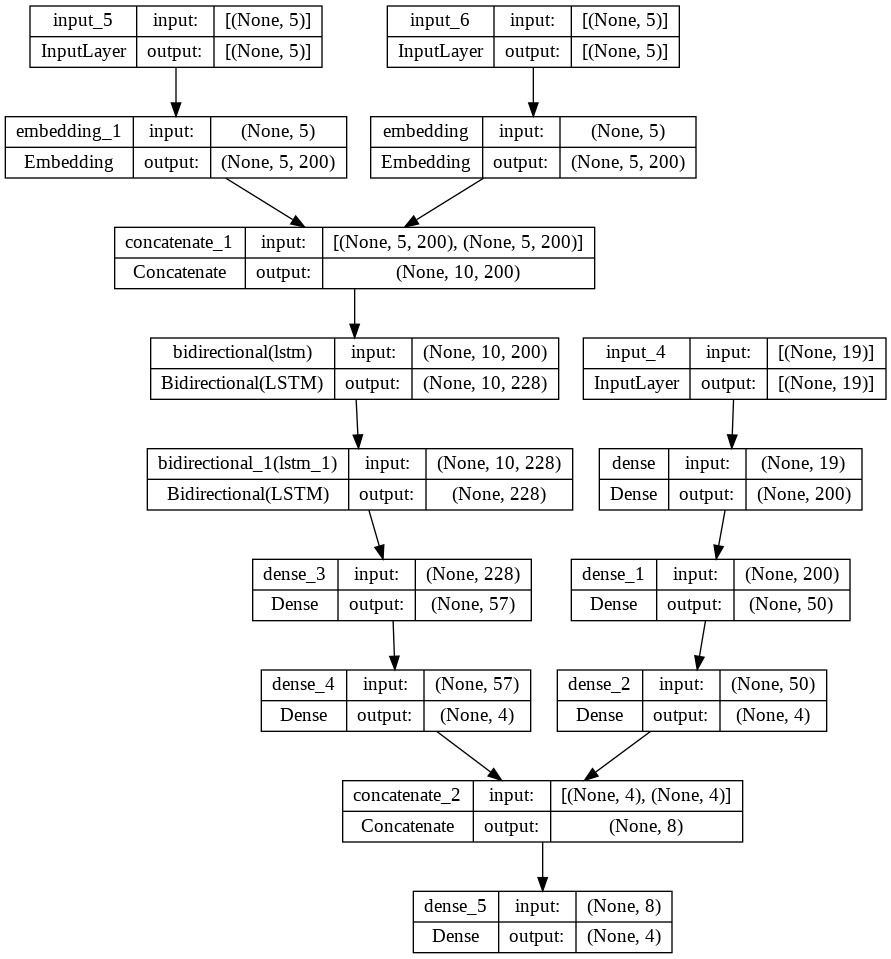

In [60]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model Evaluation

Here we evaluate the model performance on the test set to see if the model is able to learn properly from the data

In [61]:
x_test = vectorizer(np.array([[s] for s in test_samples_chief])).numpy()
x_test_his = vectorizer_his(np.array([[s] for s in test_samples_his])).numpy()
x_test_o = trans_pip.transform(test_samples_o)
y_test = np.array(test_labels)

In [62]:
y_test_pred = model.predict(x=[x_test_o,x_test_his, x_test])

2799/2799 [==============================] - 13s 4ms/step


In [63]:
class_list = [0,1,2,3]
class_indexes = np.argmax(y_test_pred, axis=1)
classes = [class_list[idx] for idx in class_indexes]

Decode the encoded classes back to the class names we grouped them to initially

In [64]:
def decode(x):
  if x==0:
    return("0 - 6")
  elif x==1:
    return("6 - 12")
  elif x==2:
    return("12 - 24")
  else:
    return("24+")

In [65]:
y_pred_test_class = classes

In [66]:
y_test = [decode(i) for i in y_test]

y_pred_test_class = [decode(i) for i in y_pred_test_class]

Scoring the model

In [67]:
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
#print("f1 score for test set:", f1_score(y_test, y_pred_test_class,average='weighted'))
cm= confusion_matrix(y_test, y_pred_test_class)

print("Classification Report for test set:\n", classification_report(y_test, y_pred_test_class))
#print("The confusion Matrix\n", cm)

accuracy score for test set: 0.6531013379196354


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for test set:
               precision    recall  f1-score   support

       0 - 6       0.68      0.95      0.79     58609
     12 - 24       0.25      0.02      0.03      7415
         24+       0.00      0.00      0.00      2081
      6 - 12       0.40      0.13      0.20     21437

    accuracy                           0.65     89542
   macro avg       0.33      0.27      0.25     89542
weighted avg       0.56      0.65      0.57     89542



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
#pick label list from the classification report
labels_list= ["0 - 6","12 - 24","24+","6 - 12"]

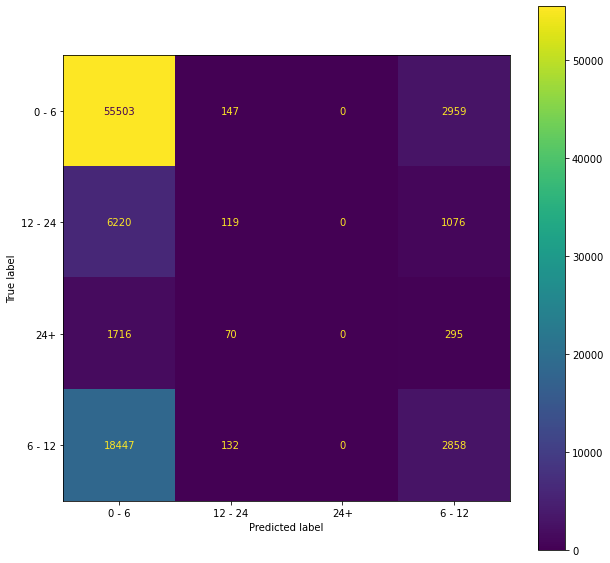

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_list)
disp.plot(ax=ax)
plt.show()

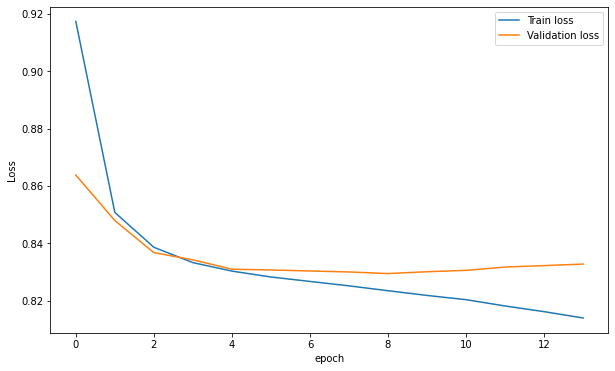

In [70]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history)

In [72]:
pd.DataFrame(x_test_o).to_csv("/content/drive/MyDrive/Capstone Project/x_test_o.csv",index=False)
pd.DataFrame(x_test).to_csv("/content/drive/MyDrive/Capstone Project/x_test.csv",index=False)
pd.DataFrame(x_test_his).to_csv("/content/drive/MyDrive/Capstone Project/x_test_his.csv",index=False)
pd.DataFrame(train_samples_o).to_csv("/content/drive/MyDrive/Capstone Project/train_samples_o.csv",index=False)
pd.DataFrame(test_samples_his).to_csv("/content/drive/MyDrive/Capstone Project/test_samples_his.csv",index=False)
pd.DataFrame(test_samples_chief).to_csv("/content/drive/MyDrive/Capstone Project/test_samples_chief.csv",index=False)
pd.DataFrame(edstay_ad1).to_csv("/content/drive/MyDrive/Capstone Project/edstay_ad1.csv",index=False)

The End